# Adding stochastic forces

In this example, we add a stochastic force to a planet. This can be used simulate migration in a turbulent disk. See e.g. [Rein (2012)](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427L..21R/abstract) and [Rein and Papaloizou (2009)](https://ui.adsabs.harvard.edu/abs/2009A%26A...497..595R/abstract). First, let's setup a REBOUND Simulation:

In [25]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.) # Star
sim.add(m=1e-3, a=1) # Jupiter mass planet
sim.move_to_com() 

We will be using the WHFast integrator with a fixed timestep. It's important to point out that the default IAS15 integrator is not well suited for stochastic forces because it automatically reduces the timestep if it doesn't achieve an accuracy near machine precision. Because the stochastic forces are noisy by design, it might never converge or reduce the timestep to a very small value.

In [26]:
sim.integrator = "whfast"
sim.dt = sim.particles[1].P/34.5678 # About 30 steps per orbit

Next, we add the `stochastic_forces` module in REBOUNDx

In [27]:
import reboundx
rebx = reboundx.Extras(sim)
sto = rebx.load_force("stochastic_forces")
rebx.add_force(sto)

We can now turn on stochastic forces for a particle by setting the particle's $\kappa$ (`kappa`) field to a finite value. This parameter determines the strength of the stochastic forces and is expressed relative to the gravitational force that the particle experiences from the centeral object.

In [28]:
sim.particles[1].params["kappa"] = 1.0e-5

You can also specify the auto-correlation time of the stochastic forces in units of the current orbital period. The default of $\tau_\kappa$ is 1, so we don't really needs this line:

In [29]:
sim.particles[1].params["tau_kappa"] = 1.0

We can now run the simulation for 10000 orbits.

In [30]:
import numpy as np
times = np.linspace(0.,1e4*np.pi*2., 1000)
semia = np.zeros(len(times))
for i, t in enumerate(times):
    sim.integrate(t)
    semia[i] = sim.particles[1].a

Let's plot the random walk of the semi-major axis.

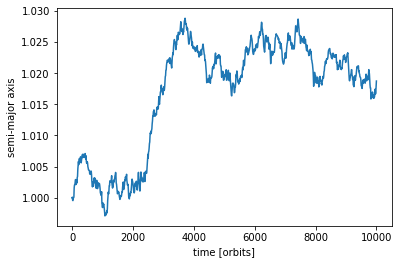

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time [orbits]")
ax.set_ylabel("semi-major axis")
ax.plot(times/np.pi/2., semia);

Let us run a few more simulations with different diffusion parameters and verify that the planet is indeed undergoing a random walk where the semi-major axes grow as $\Delta a \sim \sqrt{t}$. [Rein and Papaloizou (2009)](https://ui.adsabs.harvard.edu/abs/2009A%26A...497..595R/abstract) provide equations for all orbital elements in single planet systems as well as for libration ampltidues in two-planet systems. In our case, we are interested in the change of semi-major axis which is given by (see their Eq 46):
$$ \left( \Delta A\right)^2 = 4 \frac{D\,t}{n^2} $$
where $n$ is the mean motion of the planet and $D$ is the diffusion coefficient, given by:
$$ D = 2 \langle F^2 \rangle \tau_\kappa $$.

In [8]:
def runsim(kappa):
    sim = rebound.Simulation()
    sim.add(m=1.) # Star
    sim.add(m=1e-3, a=1) # Jupiter mass planet
    sim.move_to_com() 

    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/30.3
    
    rebx = reboundx.Extras(sim)
    sto = rebx.load_force("stochastic_forces")
    rebx.add_force(sto)
    
    sim.particles[1].params["kappa"] = kappa
    
    times = np.pi*2.*np.logspace(0.,5, 1000)
    semia = np.zeros(len(times))
    for i, t in enumerate(times):
        sim.integrate(t)
        semia[i] = sim.particles[1].a
    return times, semia

In [9]:
kappas = [1e-5, 1e-6, 1e-7]
results = np.zeros((len(kappas),1000))
for i, kappa in enumerate(kappas):
    times, results[i] = runsim(kappa)

The following plot compares the analytic predictions (dashed lines) to the numerical simulations (solid lines). Because this is a stochastic process, we can only expect that the analytic predictions hold in the average sense. This is indeed the case:

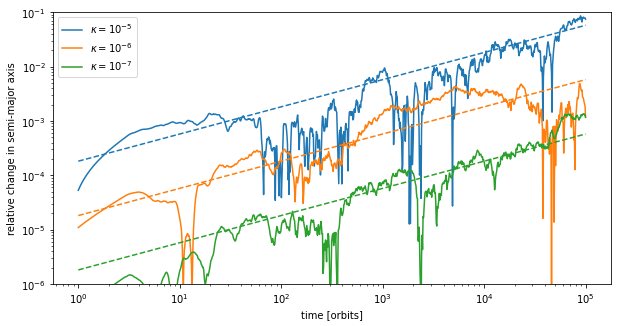

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("time [orbits]")
ax.set_ylim([1e-6,1e-1])
ax.set_ylabel("relative change in semi-major axis")
for i, kappa in enumerate(kappas):
    p = ax.plot(times/np.pi/2., np.abs(1.-results[i]), label="$\kappa = 10^{%.0f}$"%np.log10(kappa))
    tau = sim.particles[1].P
    D = 2.*kappa**2*tau
    ax.plot(times/np.pi/2., np.sqrt(4.*D/sim.particles[1].n**2*times), color=p[0].get_color(), ls="--") 
ax.legend();

The `stochastic_forces` module uses the internal pseudo random number generator of REBOUND. This means that by default, each simulation starts with a random seed. If you want to generate reproducible results, you can manually set the seed to the same value every time you run the simulation.

In [ ]:
sim.rand_seed = 123